# Oppgave 6 – Prediktiv Analyse
I denne delen av prosjektet bruker vi lineær regresjon for å forutsi miljøforhold basert på historiske vær- og luftdata. Vi bruker Python og bibliotekene `scikit-learn`, `pandas`, `matplotlib` og `seaborn` for å analysere og visualisere data. Denne notebooken bruker ferdiglagde funksjoner fra `src/` for å gjennomføre dataanalyse og prediksjon.

Målet er å:
- Trene en regresjonsmodell som kan forutsi skydekke
- Håndtere og fylle inn manglende data
- Lage tydelige visualiseringer som viser utvikling og sammenhenger

## 1. Importer nødvendige funksjoner og biblioteker

In [13]:
import sys
import os
sys.path.append(os.path.abspath("../src"))


import pandas as pd
from opg6_databehandling import Databehandling
from opg6_visualisering import PollutionVisualizer
from opg6_analyse import regresjon
from opg6_skydekkemodel import SkydekkePredictor
import matplotlib.pyplot as plt


##  Håndtering av manglende data

Manglende verdier kan påvirke analysene og resultatene våre. Derfor interpolerte vi manglende målinger i datasettet med en lineær metode. Vi valgte lineær interpolasjon fordi det gir en enkel og forståelig utfylling som følger trenden i data.

Vi har også laget visualiseringer som viser forskjellen før og etter interpolering. Dette gir bedre innsikt i hvor mye informasjon som manglet, og hvordan det påvirker datatrendene.

I tillegg brukte vi IQR-metoden for å fjerne ekstreme verdier (outliers), som kan skape feil i modelltreningen.


In [14]:

df_klima, df_luft = Databehandling.les_og_forbered_data("../data/R_Sammenslaaing_uten_feil.csv", "../data/R_luftkvalitet.csv")
df = Databehandling.slå_sammen_data(df_klima, df_luft)
df = Databehandling.fjern_outliers(df, "no2", 300)

#### Sjekker om datasettene har manglende datoer/rader siden antall rader er forksjellig:

In [15]:
df_luft_daily, df_luft_fylt = Databehandling.resample_og_interpoler(df_luft)

Antall manglende verdier før interpolering:
pm2_5    6
pm10     6
no2      6
o3       6
dtype: int64

Antall manglende verdier etter interpolering:
pm2_5    0
pm10     0
no2      0
o3       0
dtype: int64


#### Ser at luftkvalitet har noen manglende rader. Bruker linær regresjonsmetode til å lage tilnærmet verdi for de manglende radene:

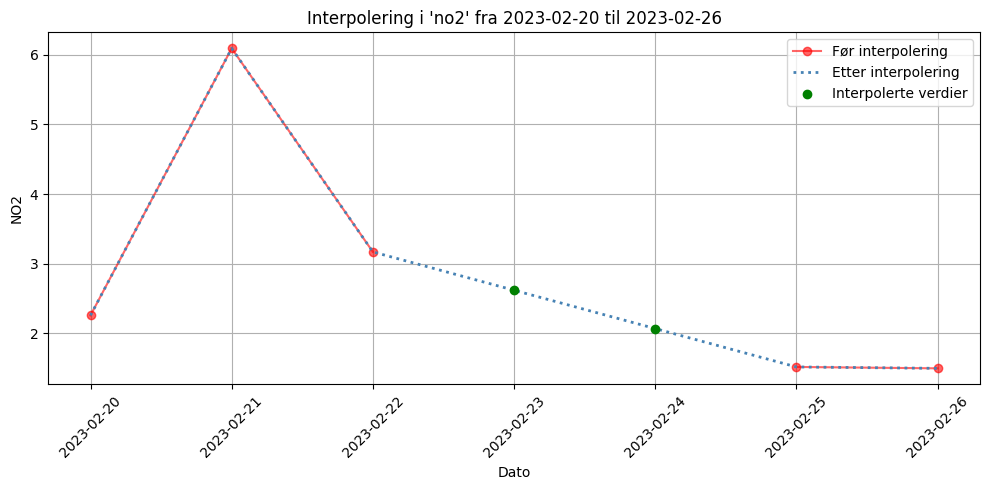

In [16]:
kolonne = "no2"
start_dato = "2023-02-20"
slutt_dato = "2023-02-26"

PollutionVisualizer.plot_interpolation(df_luft_daily, df_luft_fylt, kolonne, start_dato, slutt_dato)


#### For å vise tydlig hvordan interpoleringen er gjort blir det kun plottet et lite intervall. Plottet viser hvordan interpoleringen er blitt gjort for de manglende verdiene. 

## 3. Visualisering


#### Et linjediagram er brukt for å plotte NO₂-data fordi det gir en tydelig visuell fremstilling av konsentrasjonen over tid og gjør det enkelt å identifisere manglende verdier eller uteliggere i datasettet. Det gikk ikke å hente ut historisk data for luftkvalitet fra MET som ble tidligere brukt og dataen ble derfor hentet ut ved openweatherma. Videre plottes data for å se om det mangler eller uteliggere. 

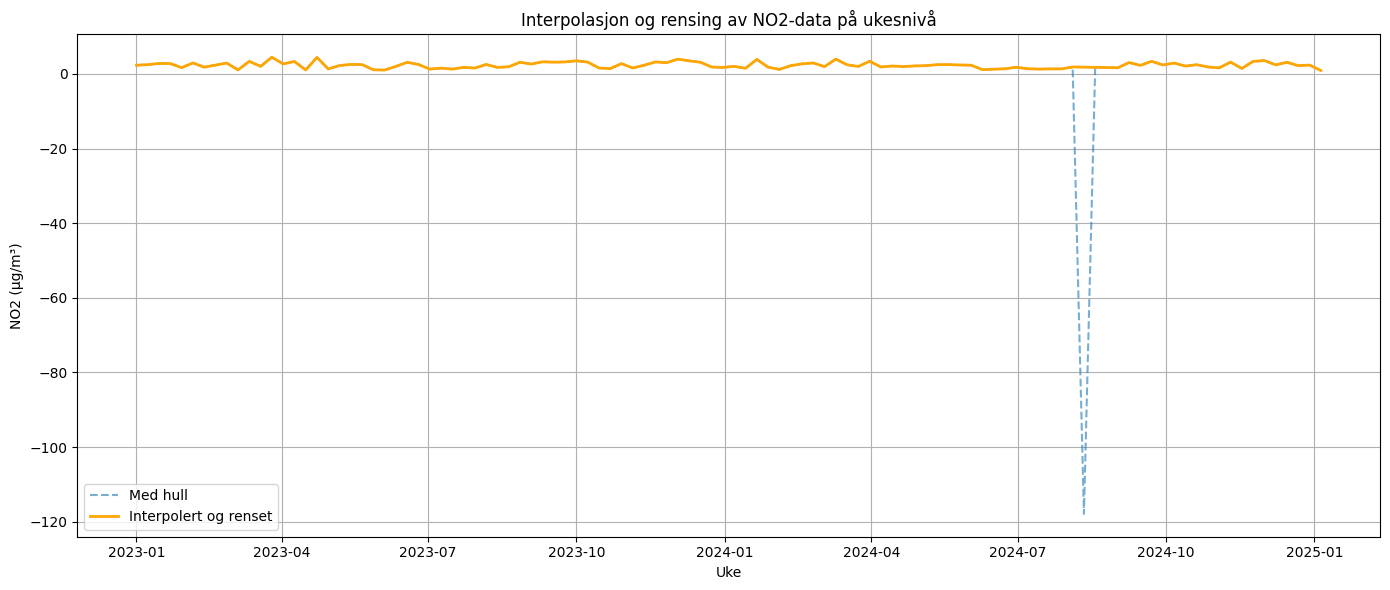

In [17]:

weekly_no2 = df_luft["no2"].resample("W").mean()
weekly_no2_clean = Databehandling.fjern_iqr_outliers(weekly_no2)
PollutionVisualizer.plot_ukentlig_no2(weekly_no2, weekly_no2_clean)


#### Ser at den er en verdi som er ugyldig, sjekker dette ved å printe ut de 10 laveste verdiene i datasettet:

In [18]:
print(weekly_no2.sort_values().head(10))

date
2024-08-11   -117.918571
2025-01-05      0.920000
2023-06-04      1.034286
2023-04-16      1.058571
2023-03-05      1.068571
2023-05-28      1.108571
2024-06-09      1.131429
2024-02-04      1.204286
2024-06-16      1.265714
2023-07-16      1.284286
Name: no2, dtype: float64


#### Ser uteligger på 08.11.2024 da dette ikke er en gyldig verdi for NO2. Metoden for å behandle uteliggere er Interquartile Range (IQR).
Utregningen er gjort i "opg6_databehandling" og er:<br>
Q1 = serie.quantile(0.25)<br>
Q3 = serie.quantile(0.75)<br>
IQR = Q3 - Q1<br>
lower_bound = Q1 - 1.5 * IQR <br>
upper_bound = Q3 + 1.5 * IQR<br>

### 2. Stolpediagram

Stolpediagram ble brukt for å sammenligne ukentlige gjennomsnittsverdier for NO₂. Dette gjør det enkelt å se forskjeller mellom uker og identifisere uker med høy forurensning.



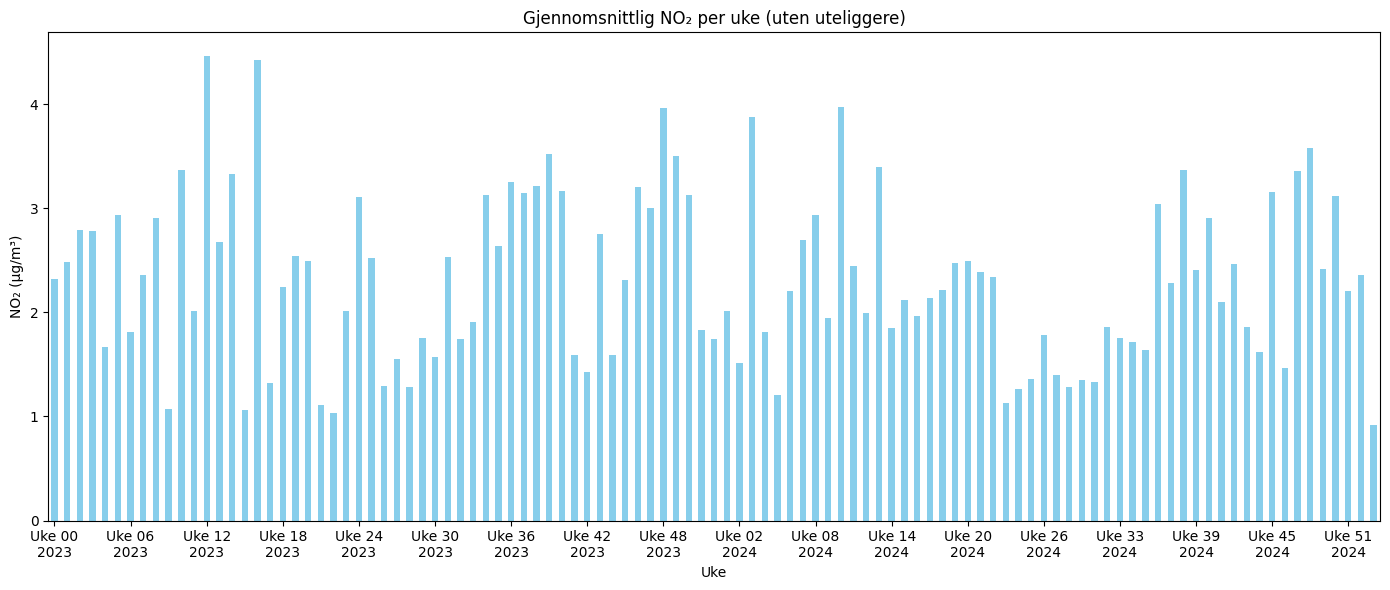

In [19]:

weekly_no2 = df_luft_daily["no2"].resample("W").mean()
weekly_no2_clean = Databehandling.fjern_iqr_outliers(weekly_no2)

PollutionVisualizer.plot_no2_ukentlig_barplot(weekly_no2_clean)


# Heatmap

Bruker heatmap til å se korrelasjon mellom alle verdiene. Dette brukes videre til å se hva som er interessant å lage visuallisering av og hvilke verdier som kan brukes til å lage predikeringsmodell.

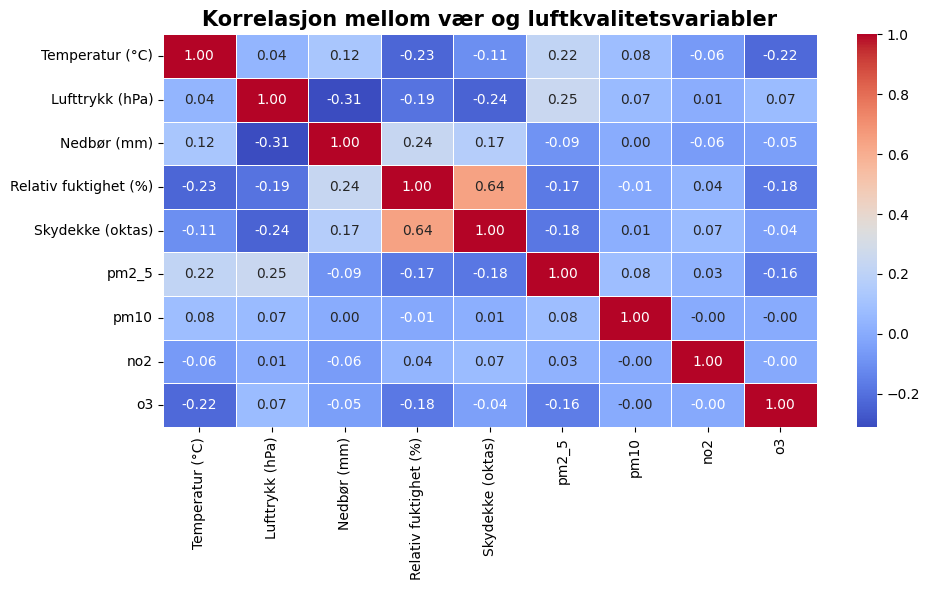

In [21]:
PollutionVisualizer.vis_korrelasjonsmatrise(df)

Ser fra heatmap at skydekke og relativ luftfuktighet har sterk korrelasjon. Ser også at nedbør og lufttrykk har sterk korrelasjon. Begge disse stemmer sterkt overens, noe som er i tråd med meteorologisk forskning, der det ofte observeres at værforhold som høy luftfuktighet og økt skydekke opptrer samtidig, samt at nedbør ofte henger sammen med lavt lufttrykk.

# Linjediagramemed Seaborn
Linjediagram er brukt for å visualisere skydekke og relativ luftfuktighet fordi denne diagramtypen egner seg godt til å vise hvordan verdier utvikler seg over tid. I tillegg gjør linjediagram det enklere å sammenligne to tidsserier (skydekke og luftfuktighet) ved å bruke to y-akser, og å se samvariasjon mellom dem.

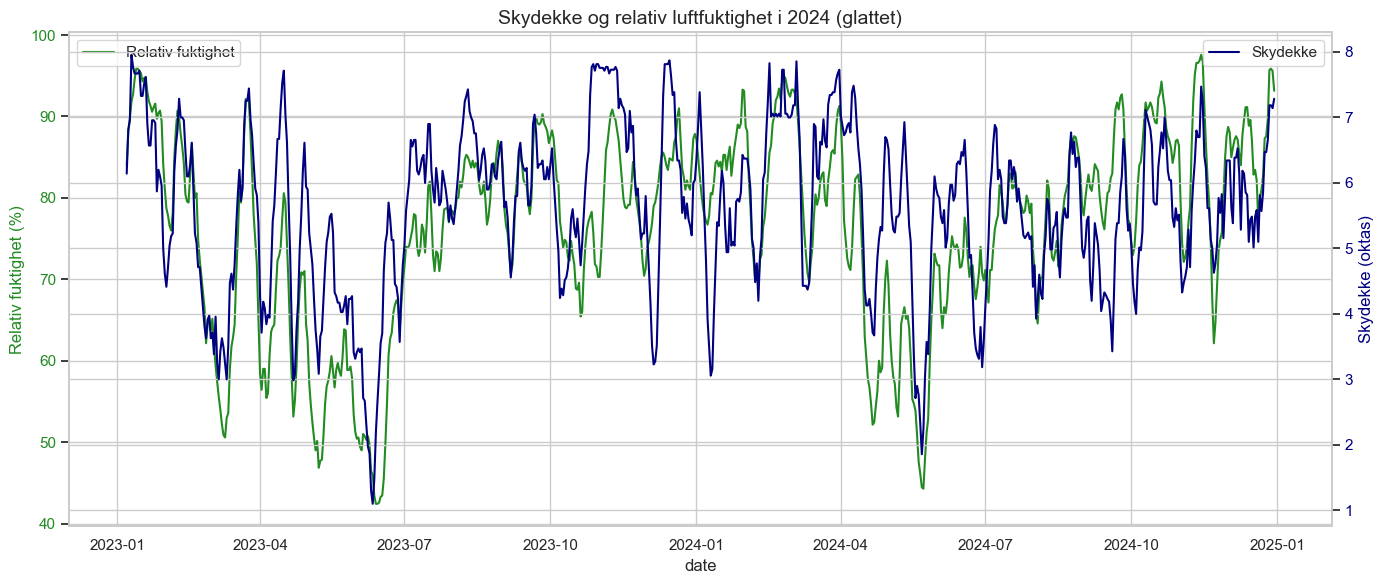

In [22]:
PollutionVisualizer.plott_skydekke_fuktighet(df)


## 4. Tren og evaluer prediktiv modell


I denne delen bruker vi en lineær regresjonsmodell til å forutsi skydekke basert på tre værvariabler:
- Temperatur (°C)
- Lufttrykk (hPa)
- Relativ fuktighet (%)

Først deles datasettet i en trenings- og en testdel. Deretter standardiserer vi input-verdiene slik at de har lik skala, noe som er viktig for at modellen skal lære riktig.

MSE: 2.87
R²: 0.38
RMSE: 1.69


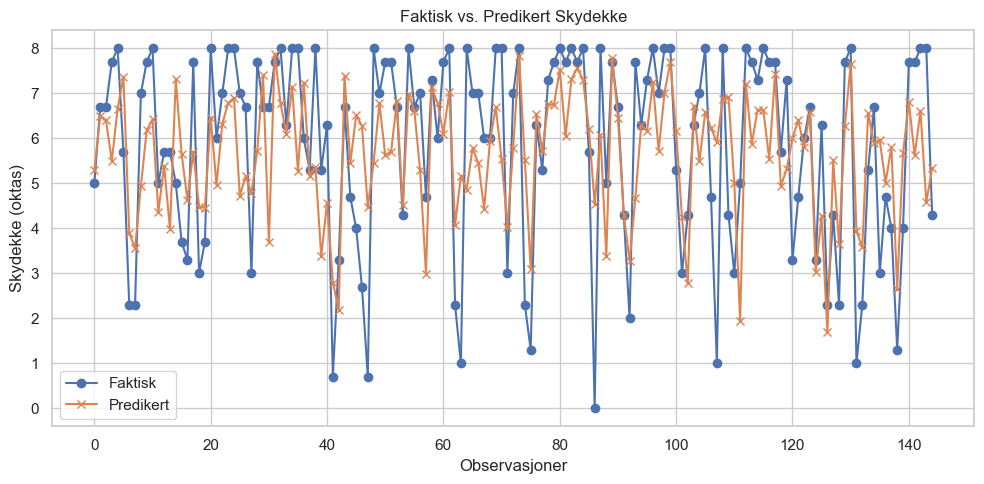

In [23]:

df_klima, df_luft = Databehandling.les_og_forbered_data("../data/R_Sammenslaaing_uten_feil.csv", "../data/R_luftkvalitet.csv")
df_samlet = Databehandling.slå_sammen_data(df_klima, df_luft)

sp = SkydekkePredictor(df_samlet)
sp.tren_og_evaluer()
sp.lagre_modell()


Mean square error regner ut gjennomsnittet av kvadrerte feil mellom de faktiske og predikerte veridene. 
RMSE er da roten av MSE og sier at feilmarginen på de predikerte veridene er i snitt 2.87. Dette betyr at modellen bommer i sitt +/- 2.87 oktas.

R*2 sier hvor mye av variasjonen skydekke-modellen som forklares av modellen. 0.38  vil si at 38% kan forklares av temperatur, lufttrykk og luftfuktighet. Dette tilsvarer ikke mye, men modellen er noe fungerende.

## 5. Anbefaling basert på en tilfeldig observasjon
Velger en random simulering for å simulere en dag og sier til bruker om sjangsen for regn ut i fra skydekke og fuktighet og da om man bør ta med paraply:
 

In [34]:
modell, scaler, metrics, X_test, y_test, y_pred = regresjon.tren_modell(df, ["Skydekke (oktas)", "Relativ fuktighet (%)"], "Nedbør (mm)")

import random

ny_observasjon = X_test.sample(1, random_state=random.randint(1, 10000))
pred = modell.predict(scaler.transform(ny_observasjon))[0]
fukt = ny_observasjon["Relativ fuktighet (%)"].values[0]
print(f"Skydekke: {pred:.2f}, Fuktighet: {fukt:.1f}%")
print(regresjon.bor_ta_med_paraply(pred, fukt))


Skydekke: 2.81, Fuktighet: 73.0%
Ingen grunn til paraply, nyt sola!


## 6. Lagre modell og scaler


In [37]:
regresjon.lagre_modell(modell, scaler, "../modell_skydekke.pkl", "../scaler_skydekke.pkl")


# Evaluering av visualiseringene
Heatmapet gjorde det enkelt å identifisere hvilke variabler som har sterk sammenheng, og hjalp oss å velge input til regresjonsmodellen. 

Linjediagrammene ga god oversikt over utvikling i verdier over tid, spesielt for sesongvariasjoner. Vi så for eksempel at skydekke var lavere om sommeren i begge årene. I tillegg viste linjediagrammet tydelig hvordan interpolering fylte ut manglende verdier.

Stolpediagrammene viste ukentlige trender på en tydelig og kompakt måte, og gjorde det enklere å oppdage uregelmessigheter eller feil i datasettet.


# Refleksjon
Vi valgte lineær regresjon fordi det er en enkel og intuitiv modell som passer godt når vi ønsker å undersøke lineære sammenhenger mellom variabler. Det gjorde det lettere å forstå hvordan hver værvariabel påvirker skydekke.

Dersom vi skulle utviklet dette videre, kunne vi testet mer avanserte modeller som beslutningstrær, eller brukt klassifikasjon for å forutsi kategorier (f.eks. "overskyet" eller "klart").

Vi lærte også verdien av å kombinere visuelle fremstillinger med numeriske målinger (MSE, RMSE og R²). Det ga oss et mer helhetlig bilde av hvor god modellen var, både teknisk og visuelt.


